### Vicsek Model Simulations

**Authors:** Subhanik Purkayastha and Dhananjay Bhaskar

**Last Modified:** Feb 16, 2019

In [1]:
import os
import math
import pprint
import numpy as np
import random as nr
from IPython.display import HTML
from optparse import OptionParser

import matplotlib
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot

import multiprocessing
from joblib import Parallel, delayed

init_notebook_mode(connected=True)

matplotlib.rc('xtick', labelsize=6) 
matplotlib.rc('ytick', labelsize=6) 
matplotlib.rcParams.update({'font.size':8})

%matplotlib inline

#### Parameter values

In [2]:
# simulation params
initN = 20            # must be even number greater than 2 for now
timePoints = 100

# model params
r = 20
attraction = 30

np.random.seed(1337)
periodicBounds = True

# cell division params
cellDiv = True
cellDivRate = 10
divisionTimeMu = 30 # 15
divisionTimeStd = 3

#### Save simulation config

In [3]:
def saveConfig(JID, N, timepoints, r, attraction, cellDivRate, periodicBounds, cellDiv):
    filename = "JobID:" + str(JID) + ".txt"
    f = open(filename, "w+")
    params = [JID, N, timepoints, r, attraction, cellDivRate, periodicBounds, cellDiv]
    name = ["JobID: ", "# cells: ", "# timepoints: ", "r: ", "attraction: ", 
            "Rate of cell division: ", "Periodic Boundary Conditions: ", "Cell Division: "]
    for args in range(len(params)):
        f.write(name[args] + str(params[args]) + "\n")

def setParams(file):
    global N
    global timePoints
    global r
    global attraction
    global cellDivRate
    global periodicBounds
    global cellDiv
    with open(file) as currJob:
        for line in currJob:
            val = line.split(": ")
            if val[0] in ("# cells"):
                N = int(val[len(val)-1])
            elif val[0] in ("# timepoints"):
                timePoints = int(val[len(val)-1])
            elif val[0] in ("r"):
                r = int(val[len(val)-1])
            elif val[0] in ("attraction"):
                attraction = int(val[len(val)-1])
            elif val[0] in ("Rate of cell division"):
                cellDivRate = int(val[len(val)-1])
            elif val[0] in ("Periodic Boundary Conditions"):
                if val[len(val)-1] == "True\n":
                    periodicBounds = True
                else:
                    periodicBounds = False
            else:
                if val[len(val)-1] in "True\n":
                    cellDiv = True
                else:
                    cellDiv = False

#### Helper functions

In [4]:
def findAngle(events, cid):
    return pos[events][cid]['a']

def getColor(events, cid):
    return pos[events][cid]['c']

def averageTheta(event, cell):
    global N
    global pos
    theta = pos[event][cell]['a']
    count = 1.0
    for cid in range(N):
        if(pos[event][cell]['x'] + attraction > 1000):
            if((pos[event][cid]['x'] < (-1000+(attraction-(1000-pos[event][cell]['x'])))) and 
               (abs(pos[event][cid]['y'] - pos[event][cell]['y']) <= attraction)):
                thetha=theta+pos[event][cid]['a']
                count+=count+1.0
        if(pos[event][cell]['x'] - attraction < -1000):
            if((pos[event][cid]['x'] > (1000-(attraction+(-1000-pos[event][cell]['x'])))) and 
               (abs(pos[event][cid]['y'] - pos[event][cell]['y']) <= attraction)):
                theta=theta+pos[event][cid]['a']
                count=count+1.0
        if(pos[event][cell]['y'] + attraction > 1000):
            if((pos[event][cid]['y'] < (-1000+(attraction-(1000-pos[event][cell]['y'])))) and 
               (abs(pos[event][cid]['x'] - pos[event][cell]['x']) <= attraction)):
                thetha=theta+pos[event][cid]['a']
                count=count+1.0
        if(pos[event][cell]['y'] - attraction < -1000):
            if((pos[event][cid]['y']>(1000-(attraction+(-1000-pos[event][cell]['y'])))) and 
               (abs(pos[event][cid]['x'] - pos[event][cell]['x']) <= attraction)):
                theta=theta+pos[event][cid]['a']
                count=count+1.0
        if((abs(pos[event][cid]['x'] - pos[event][cell]['x']) <= attraction) and 
           (abs(pos[event][cid]['y'] - pos[event][cell]['y']) <= attraction)):
            theta=theta + pos[event][cid]['a']
            count=count+1.0
    return (theta/count)
            
def getXPosition(cid, t):
    x_data = list()
    if cid in pos[t].keys():
        x_data.append(pos[t][cid]['x'])
    return x_data

def getYPosition(cid, t):
    y_data = list()
    if cid in pos[t].keys():
        y_data.append(pos[t][cid]['y'])
    return y_data

def getName(num):
    numZeros = 5 - len(repr(num))
    name = ""
    for i in range(numZeros):
        name += '0'
    name += repr(num)
    name += ".png"
    return name

def areInteracting(cell, event):
    global pos
    frame_N = np.max(pos[event].keys())
    for cid in range(frame_N):
        if ((abs(pos[event][cid]['x'] - pos[event][cell]['x']) <= attraction) and 
            (abs(pos[event][cid]['y'] - pos[event][cell]['y']) <= attraction)):
                plt.plot([pos[event][cid]['x'], pos[event][cell]['x']], 
                         [pos[event][cid]['y'], pos[event][cell]['y']], 
                         '-', linewidth=0.5, color='darkgray')
            
def showTrail(cell, event):
    if (event <= 10):
        for i in range(event):
            plt.plot([pos[i][cell]['x'], pos[i+1][cell]['x']], [pos[i][cell]['y'], pos[i+1][cell]['y']], 
                     'k--', linewidth=0.5)
    else:
        for i in range(10):
            plt.plot([pos[event-i-1][cell]['x'], pos[event-i][cell]['x']], 
                     [pos[event-i-1][cell]['y'], pos[event-i][cell]['y']], 
                     'g--', linewidth=0.5)

def setInitialCircle():
    x = list()
    y = list()
    for n in range(N):
        angle = nr.uniform(0,1)*(math.pi*2)
        x.append(800*math.cos(angle));
        y.append(800*math.sin(angle));
    
    for i in range(N):
        firstPos[i] = dict()
        for j in ['x', 'y', 'a', 'c']:
            if (j == 'c'):
                firstPos[i][j] = 'b'
            if (j == 'x'):
                firstPos[i][j] = x[i];
            if (j == 'y'):
                firstPos[i][j] = y[i];
            if (j == 'a'):
                if(firstPos[i]['x'] > 0):
                    firstPos[i][j] = math.pi+math.atan((firstPos[i]['y'])/(firstPos[i]['x']))
                else:
                    firstPos[i][j] = math.atan((firstPos[i]['y'])/(firstPos[i]['x']))
                        
def setOrbitingCircle():
    angle = 0
    delta_theta = (2*math.pi)/N
    pos = list()
    for n in range(N):
        pos.append([800*math.cos(angle), 800*math.sin(angle)]);
        angle = angle+delta_theta
    
    for i in range(N-1):
        firstPos[i] = dict()
        for j in ['x', 'y', 'a', 'c']:
            if (j == 'c'):
                firstPos[i][j] = 'b'
            if (j == 'x'):
                firstPos[i][j] = pos[i][0];
            if (j == 'y'):
                firstPos[i][j] = pos[i][1];
            if (j == 'a'):
                if(firstPos[i]['y'] > 0 and firstPos[i]['x'] > 0):
                    firstPos[i][j] = math.atan((pos[i+1][1]-pos[i][1])/(pos[i+1][0]-pos[i][0]))
                elif(firstPos[i]['y'] > 0 and firstPos[i]['x'] < 0):
                    firstPos[i][j] = (math.pi/2)+math.atan((pos[i+1][0]-pos[i][0])/(pos[i+1][1]-pos[i][1]))
                elif(firstPos[i]['y'] < 0 and firstPos[i]['x'] > 0):
                    firstPos[i][j] = math.atan((pos[i+1][0]-pos[i][0])/(pos[i+1][1]-pos[i][1]))-(math.pi)
                else:
                    firstPos[i][j] = math.pi+math.atan((pos[i+1][0]-pos[i][0])/(pos[i+1][1]-pos[i][1]))

def setDiagonal():
    x = np.linspace(-800, 800)
    y = np.linspace(-800, 800)
    for i in range(N):
        firstPos[i] = dict()
        for j in ['x', 'y', 'a', 'c']:
            if (j == 'c'):
                firstPos[i][j] = 'b'
            if (j == 'x'):
                firstPos[i][j] = x[i];
            if (j == 'y'):
                firstPos[i][j] = y[i];
            if (j == 'a'):
                if(firstPos[i]['x'] > 0):
                    firstPos[i][j] = math.pi+math.atan((firstPos[i]['y'])/(firstPos[i]['x']))
                else:
                    firstPos[i][j] = math.atan((firstPos[i]['y'])/(firstPos[i]['x']))

def setGrid():
    halfN = N/2
    x = np.linspace(-800, 800, num=halfN)
    y = np.linspace(-800, 800, num=halfN)
    c = 0
    for row in range(y.size):
        for col in range(x.size):
            firstPos[c] = dict()
            firstPos[c]['x'] = x[col];
            firstPos[c]['y'] = y[row];
            if(firstPos[c]['x'] >= 0):
                firstPos[c]['a'] = math.pi+math.atan((firstPos[c]['y'])/(firstPos[c]['x']))
            else:
                firstPos[c]['a'] = math.atan((firstPos[c]['y'])/(firstPos[c]['x']))
            firstPos[c]['t'] = np.floor(np.random.normal(divisionTimeMu, divisionTimeStd))
            c = c + 1
            
def cellDivide(event, cell):
    global nextPos
    global pos
    global N
    
    if cellDiv is True:
        if event == 0:
            return((False, pos[event][cell]['t']-1))
        elif pos[event][cell]['t'] < 0:
            # return updated timer for parent cell
            new_timer_val = np.floor(np.random.normal(divisionTimeMu, divisionTimeStd))
            return((True, new_timer_val))
        elif event > 0:
            return((False, pos[event][cell]['t']-1))
    else:
        return 0

#### Run simulation

In [5]:
pp = pprint.PrettyPrinter(indent=4)
N = initN

pos = list()
numCells = list()

firstPos = dict()
pos.append(firstPos)

#setParams("JobID_1.txt")
#print(repr(N) + ", " + repr(timePoints) + ", " + repr(attraction)+ ", " + repr(r) + ", " + repr(cellDivRate))
#print(cellDiv)
#print(periodicBounds)

setGrid();
#setInitialCircle();
#setDiagonal();
#setOrbitingCircle();

#print("\nSTATE (ITR = INITIAL) :")
#pp.pprint(pos)

for events in range(timePoints):
    
    nextPos = dict()
    divided_cells = list()
    
    for i in range(N):
        nextPos[i] = dict()
        for j in ['c', 'x', 'y', 'a', 't']:
            if(j=='x'):
                if(pos[events][i][j] > 1000):
                    pos[events][i][j] = -1000
                elif(pos[events][i][j] < -1000):
                    pos[events][i][j] = 1000
                nextPos[i][j] = pos[events][i][j]+(math.cos(pos[events][i]['a'])*r) 
            elif(j=='y'):
                if(pos[events][i][j] > 1000):
                    pos[events][i][j] = -1000
                elif(pos[events][i][j] < -1000):
                    pos[events][i][j] = 1000
                nextPos[i][j] = pos[events][i][j]+(math.sin(pos[events][i]['a'])*r)
            elif (j=='c'):
                nextPos[i][j] = 'b'
            elif (j=='a'):
                nextPos[i][j] = averageTheta(events, i)
            else:
                (did_divide, nextPos[i][j]) = cellDivide(events, i)
                if did_divide == True:
                    divided_cells.append(i)
    
    # cell division
    if len(divided_cells) > 0:
        for cid in divided_cells:
            nextPos[N] = dict({'c': pos[events][cid]['c'], 
                                'x' : pos[events][cid]['x'] + np.random.normal(2,1), 
                                'y' : pos[events][cid]['y'] + np.random.normal(2,1), 
                                'a' : pos[events][cid]['a'] + math.pi, 
                                't' : np.floor(np.random.normal(divisionTimeMu, divisionTimeStd))})
            N = N + 1
    
    numCells.append(N)
    pos.append(nextPos)
    
#print("\nSTATE (ITR = " + repr(events) + ") :")
#pp.pprint(pos)

#### Analysis of results

Text(0,0.5,u'Number of Cells')

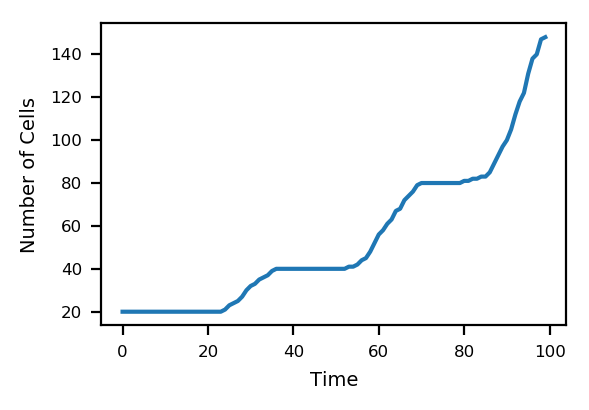

In [6]:
plt.figure(figsize=(3,2), dpi=200)
plt.plot(range(timePoints), numCells)
plt.xlabel("Time", size=7)
plt.ylabel("Number of Cells", size=7)

In [7]:
num_cores = multiprocessing.cpu_count()
print "Number of cores: " + repr(num_cores)
print "Number of cells: " + repr(N)

Number of cores: 4
Number of cells: 148


#### Plot frame
- **TODO**: Fix `showTrail` function to deal with cell division and periodic boundary conditions

In [8]:
tpoints = range(timePoints) 

def createPlot(frame):
    
    matplotlib.rc('xtick', labelsize=4) 
    matplotlib.rc('ytick', labelsize=4) 
    matplotlib.rcParams.update({'font.size':6})
    
    plt.figure(figsize=(4,3), dpi=400)
    plt.xlim([-1000,1000])
    plt.ylim([-1000,1000])
    
    numcellsinframe = np.max(pos[frame].keys()) + 1
    
    for cid in range(numcellsinframe):
        xloc = getXPosition(cid, frame)[0]
        yloc = getYPosition(cid, frame)[0]
        theta_val = findAngle(frame, cid)
        plt.plot(xloc, yloc, marker='o', color='#2222ee', alpha=0.7, linestyle='None', markersize=4)
        areInteracting(cid, frame)
        #showTrail(cid, frame)
        #plt.quiver(xloc, yloc, 0.5*math.cos(theta_val), 0.5*math.sin(theta_val), angles='xy', 
        #           width=0.003, color='black')
        plt.plot([xloc, xloc+50*math.cos(theta_val)], [yloc, yloc+50*math.sin(theta_val)], 'k-', linewidth=0.5)
        
    plt.tight_layout()
    plt.savefig(getName(frame))
    plt.close()
    
    return(getName(frame))

#### Generate frames for movie

In [9]:
createPlot(100)

'00100.png'

In [10]:
results = Parallel(n_jobs=num_cores)(delayed(createPlot)(frame) for frame in tpoints)

**Encode movie**

In [11]:
! chmod +x make_png_movie.sh
! ./make_png_movie.sh

Creating Movie - Frames: 101 Estimated Length: 10 seconds
ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex

#### Rename movie file

In [13]:
! mv my_movie.mp4 SimulationResults/staggered_growth.mp4

mv: cannot move 'my_movie.mp4' to 'SimulationResults/cell_division_grid.mp4': No such file or directory


#### Delete images and embed video

In [14]:
! rm -rf *.png

In [15]:
HTML("""
<video width="640" height="640" controls>
  <source src="SimulationResults/staggered_growth.mp4" type="video/mp4">
</video>
""")